**Arian Tashakkor - 40023494: Computer Assignment #2**

# Preparation

Downloading and unzipping the datasets used in the problems:

Importing libraries:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Problem 1

## 0. Loading and Displaying the Dataset

In [2]:
test_features = pd.read_csv("data/TinyMNIST/testData.csv", header=None).to_numpy()
test_targets = np.squeeze(pd.read_csv("data/TinyMNIST/testLabels.csv", header=None, dtype=int).to_numpy())
train_features = pd.read_csv("data/TinyMNIST/trainData.csv", header=None).to_numpy()
train_targets = np.squeeze(pd.read_csv("data/TinyMNIST/trainLabels.csv", header=None, dtype=int).to_numpy())

Each sample from each dataset has exactly 196 features. Assuming the square-shaped images, each sample must represent a $14\times14$ flattened image. We can display one of the images as a proof of concept.

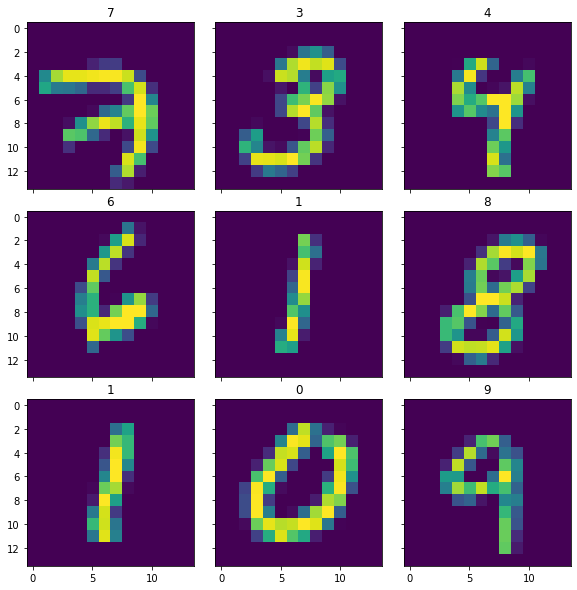

In [3]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.3)
for ax, i in zip(grid, np.arange(9)):
    ax.set_title(f'{train_targets[i]}')
    ax.imshow(train_features[i].reshape((14,14)))
plt.show()

## A1. Naive Bayes vs. Optimal Bayes: An Overview

The Naive Bayes assumption refers to an assumption made regarding the data that each singular feature from the feature vector has no correlation with other features. More formally, if the set of all features is defined as $[X_1, X_2, ..., X_s]^T$, the Naive Bayes assumption states that:

$\forall 1 \le i, j \le s, i\ne j: E[(X_i - E[X_i])(X_j - E[X_j])] = 0$

This means that for this particular problem, under the Naive Bayes assumption, the covariance matrix of the features must be forced to be a diagonal. I.e., we only use the variance of each feature individually and assume independence from other features. It has been shown that the Naive Bayes assumption, can achieve reasonably accurate results even when the assumption does not necessarily for a given feature vector. 

For instance, for this problem specifically, since we are dealing with image data where each pixel represents a feature in our 196-dimensional feature vector, the Naive Bayes assumption can be especially detrimental because handwritten digits are composed of connected areas where pixels have non-zero values. This connectedness creates a correlation between the values of different features: where we see $0$ s we expect to see $0$ in the neighborhood of that feature, and where we non-zeros we expect to see non-zero values in the neighborhood of that feature.

Optimal Bayes, disregards this assumption and in fact, works with given posterior probabilities $P(Y|X)$.

In other words, given $P(Y|X)$ the Optimal Bayes classifier, when presented with a new input vector $X_{test}$ , will calculate $P(Y|X_{test})$ for all possible values of $Y$ and pick the one with the highest posterior probability. I.e.:

$OptimalBayes(X_{test}) = argmax_{(Y)}[{P(Y|X_{test})}]$

However, since this data is unavailable in real life (in this problem, $P(Y|X)$ would be akin to knowing the exact probability of each class occurring given a specific feature map. Because no two numbers look exactly alike, then $P(Y|X)$ is close to 0 for every given X) we estimate the Optimal Bayes classifier by using the actual covariance matrix instead of its diagonal.


## A2. Bayes Classifier Implementation

We will implement a class that can handle both Naive Bayes classification and an estimate of the Optimal Bayes classification.

This class is initialized with a matrix of features, targets and whether we want to assume Naive Bayes.

Using its "predict" method we are able to classify new data samples. **The only assumption that is made regarding the data is that the labels must be categorical starting from 0.**

We will also need a function to calculate the multivariate normal pdf using the following formula:

$mvnpdf(x, \mu, \Sigma):$

$$\frac{1}{\sqrt{(2\pi)^l |\Sigma|}}e^{(-\frac{1}{2}(x - \mu)^T\Sigma^{-1}(x-\mu))} $$

However there is a problem with the implementation of this formulation. The $(2\pi)^l$ term in the denominator can cause an overflow error. In order to address this, we will calculate the log of the pdf and then exponentiate it to obtain the actual pdf. I.e.:

$mvnpdf(x, \mu, \Sigma):$



$$e^{-\frac{1}{2}(l.ln(2\pi) + ln(|\Sigma|) + (x - \mu)^T\Sigma^{-1}(x-\mu))}$$

Furthermore, due to the computational complexity of the above formulation and the fact that $|\Sigma|$ and $\Sigma^{-1}$ can cause singularity issues. We take a different approach.

The covariance matrix is Hermitian, therefore it has an eigendecomposition, i.e.:

$$ \Sigma = Q\Lambda Q^T$$

Where $Q$ is an orthogonal matrix whose colums are the eigenvectors of $\Sigma$ and $\Lambda$ is a diagonal matrix with the respective eigenvalues of $Q$.

We can leverage the fact that $Q$ is orthogonal to see that $Q^T = Q^{-1}$ and with that we can compute the inverse of $\Sigma$ as follows:

$$\Sigma^{-1} = (Q\Lambda Q^T)^{-1} = (Q^T)^{-1}\Lambda^{-1}Q^{-1} = Q\Lambda^{-1}Q^T$$

Moreover, since we know that $\Lambda$ is a diagonal matrix, $\Lambda^{-1}$ is just one over each value along the diagonal of $\Lambda$ which is easy to compute.

This takes care of $\Sigma^{-1}$, in order to calculate $|\Sigma|$, we take advantage of the fact that if we know the eigenvalues of an $l\times l$ matrix, $\lambda_1, \lambda_2, \cdots ,\lambda_l$ the determinant of such matrix is simply the product of all of its eigenvalues $\prod_{i=1}^{l}\lambda_i$. The eigenvalues of a matrix might be small which means the following product might amount to zero due to precision error, but since we are calculating the log-probabilty and then exponentiating we work with $\sum_{i=1}^{l}ln(\lambda_i)$ which is more numerically stable.

A final optimization we can do is that instead of naively computing the term $(x - \mu)^T\Sigma^{-1}(x-\mu)$ we can rewrite it as follows:

$$ (x - \mu)^T\Sigma^{-1}(x- \mu) = (x-\mu)^T Q\Lambda^{-1}Q^T(x - \mu) = (x-\mu)^T Q\sqrt{\Lambda^{-1}}\sqrt{\Lambda^{-1}}Q^T(x-\mu)$$

Setting $A =  (x-\mu)^T Q\sqrt{\Lambda^{-1}}$, we get:

$$ (x - \mu)^T\Sigma^{-1}(x- \mu) = AA^T $$

Which means we can just calculate $A$ and then simply square its values.

In [4]:
# multivariate normal pdf
def mvnpdf(x, mu, sigma, var_smoothing=1e-9):
  # suppress overflow warnings, they don't matter for the purposes of pdf
  # after performing the optimizations described above
  import warnings
  warnings.filterwarnings('ignore')
  # var_smoothing adds a constant epsilon value to the diagonals of sigma
  # in order to maintain computational stability
  if len(np.shape(sigma)) == 1:
    sigma = np.diag(sigma)
  sigma = sigma + var_smoothing*np.max(sigma)*np.eye(np.shape(sigma)[0])
  Lambda, Q = np.linalg.eigh(sigma)
  logdet = np.sum(np.log(Lambda))
  Lambda_inv = 1./Lambda
  l = len(Lambda)
  dev = x - mu
  A = np.dot(dev, Q * np.sqrt(Lambda_inv))
  maha_squared = np.square(A).sum(axis=1)
  log2pi = np.log(2 * np.pi)
  return np.exp(-0.5 * (l * log2pi + maha_squared + logdet))

In [5]:
class Bayes():
    def __init__(self, X, y, naive=True):
        self._samples = X
        self._targets = y
        self._C = np.unique(self._targets)
        self._classes = {t:[] for t in self._C}
        self._distributions = {}
        for idx, sample in enumerate(self._samples):
            self._classes[np.squeeze(self._targets[idx]).item()].append(sample)
        # calculate the mean and covariance for each class
        # if naive bayes assumption is made, only take the diagonal of the covariance matrix (variances)    
        for c in self._classes.keys():
            sigma = np.cov(np.asarray(self._classes[c]), rowvar=False)
            self._distributions[c] = {
                "mu": np.mean(np.asarray(self._classes[c]), axis=0),
                "sigma": np.diag(sigma) if naive else sigma
            }
    
    def _predict_all(self, X):
        predictions = {}
        for c in self._C:    
            predictions[c] = mvnpdf(
                    X,
                    self._distributions[c]["mu"],
                    self._distributions[c]["sigma"]
                )
        return predictions

    def predict(self, X):
        retval = []
        predictions = self._predict_all(X)
        for i in range(len(X)):
            retval.append(np.argmax([predictions[c][i] for c in self._C]))
        return retval

We will also implement a metrics class in order to calculate different metrics and be able to plot the confusion matrix.

In [6]:
class Metrics():
    def __init__(self, y_true, y_pred):
        assert len(y_true) == len(y_pred), "y_true and y_pred must be of same length"
        self._y_true = np.asarray(y_true)
        self._y_pred = np.asarray(y_pred)
        self._C = len(np.unique(np.concatenate((y_true, y_pred))))
        self._len = len(y_pred)
        self._conf_mat = self._confusion_matrix()

    def _confusion_matrix(self):
        conf_mat = np.zeros((self._C, self._C), dtype=int)
        for i in range(self._len):
            # dims = true x pred
            conf_mat[self._y_true[i], self._y_pred[i]] += 1
        return conf_mat

    @property
    def accuracy(self):
        return np.sum(self._y_true == self._y_pred)/self._len

    @property
    def precision(self):
        return np.asarray([self._conf_mat[i,i]/(np.sum(self._conf_mat[i,:])) for i in range(self._C)])

    @property
    def recall(self):
        return np.asarray([self._conf_mat[i,i]/(np.sum(self._conf_mat[:,i])) for i in range(self._C)])
    
    @property
    def f1_score(self):
        return (2* self.precision * self.recall)/(self.precision + self.recall)

    def display_confusion_matrix(self):
        import seaborn as sns
        df_conf_mat = pd.DataFrame(self._conf_mat, range(self._C), range(self._C))
        sns.heatmap(df_conf_mat, annot=True, fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

We may now begin the experiments.

## A3. Experiments

### 1. Naive Bayes

In [7]:
# initialization and prediction
nb = Bayes(train_features, train_targets)
y_pred_train = nb.predict(train_features)
y_pred_test = nb.predict(test_features)

In [8]:
# metrics initialization
metrics_nb_train = Metrics(train_targets, y_pred_train)
metrics_nb_test = Metrics(test_targets, y_pred_test)

Training Accuracy: 0.599
Average Precision: 0.5867504907524342
Precision per Class:
	0: 0.9406130268199234
	1: 0.9716312056737588
	2: 0.40159045725646125
	3: 0.36178107606679033
	4: 0.7887640449438202
	5: 0.09557109557109557
	6: 0.8947368421052632
	7: 0.7057692307692308
	8: 0.504149377593361
	9: 0.2028985507246377
Average Recall: 0.680866301940043
Recall per Class:
	0: 0.7105643994211288
	1: 0.5341130604288499
	2: 0.9308755760368663
	3: 0.7959183673469388
	4: 0.5101744186046512
	5: 0.8541666666666666
	6: 0.7379421221864951
	7: 0.7474541751527495
	8: 0.2924187725631769
	9: 0.6950354609929078
Average F1-score: 0.5568004779872082
F1-score per Class
	0: 0.809563066776587
	1: 0.6893081761006289
	2: 0.5611111111111111
	3: 0.4974489795918367
	4: 0.619593998234775
	5: 0.1719077568134172
	6: 0.8088105726872247
	7: 0.7260138476755686
	8: 0.37014470677837014
	9: 0.3141025641025641


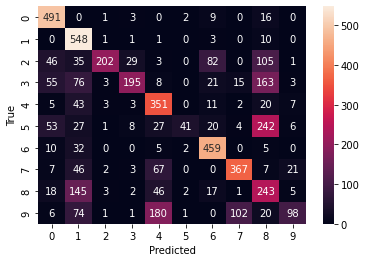

In [9]:
# train metrics
print(f'Training Accuracy: {metrics_nb_train.accuracy}')
print(f'Average Precision: {np.mean(metrics_nb_train.precision)}')
print(f'Precision per Class:')
for c in range(10):
    print(f'\t{c}: {metrics_nb_train.precision[c]}')
print(f'Average Recall: {np.mean(metrics_nb_train.recall)}')
print(f'Recall per Class:')
for c in range(10):
    print(f'\t{c}: {metrics_nb_train.recall[c]}')
print(f'Average F1-score: {np.mean(metrics_nb_train.f1_score)}')
print(f'F1-score per Class')
for c in range(10):
    print(f'\t{c}: {metrics_nb_train.f1_score[c]}')
metrics_nb_train.display_confusion_matrix()

Testing Accuracy: 0.5348
Average Precision: 0.529879893917303
Precision per Class:
	0: 0.91324200913242
	1: 0.9721254355400697
	2: 0.25
	3: 0.2795275590551181
	4: 0.7709090909090909
	5: 0.06787330316742081
	6: 0.8177777777777778
	7: 0.642023346303502
	8: 0.4090909090909091
	9: 0.1762295081967213
Average Recall: 0.6254276247270399
Recall per Class:
	0: 0.6389776357827476
	1: 0.5185873605947955
	2: 0.8023255813953488
	3: 0.7634408602150538
	4: 0.4930232558139535
	5: 0.8333333333333334
	6: 0.5626911314984709
	7: 0.6707317073170732
	8: 0.2544987146529563
	9: 0.7166666666666667
Average F1-score: 0.4865034819978731
F1-score per Class
	0: 0.7518796992481204
	1: 0.6763636363636364
	2: 0.38121546961325964
	3: 0.4092219020172911
	4: 0.601418439716312
	5: 0.12552301255230125
	6: 0.6666666666666667
	7: 0.6560636182902585
	8: 0.31378763866877973
	9: 0.28289473684210525


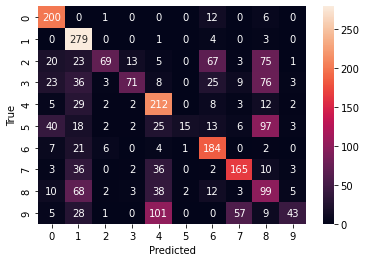

In [10]:
# test metrics
print(f'Testing Accuracy: {metrics_nb_test.accuracy}')
print(f'Average Precision: {np.mean(metrics_nb_test.precision)}')
print(f'Precision per Class:')
for c in range(10):
    print(f'\t{c}: {metrics_nb_test.precision[c]}')
print(f'Average Recall: {np.mean(metrics_nb_test.recall)}')
print(f'Recall per Class:')
for c in range(10):
    print(f'\t{c}: {metrics_nb_test.recall[c]}')
print(f'Average F1-score: {np.mean(metrics_nb_test.f1_score)}')
print(f'F1-score per Class')
for c in range(10):
    print(f'\t{c}: {metrics_nb_test.f1_score[c]}')
metrics_nb_test.display_confusion_matrix()

### 2. Estimation of Optimal Bayes

In [11]:
# initialization and prediction
obe = Bayes(train_features, train_targets, naive=False)
y_pred_train = obe.predict(train_features)
y_pred_test = obe.predict(test_features)

In [12]:
# metrics initialization
metrics_obe_train = Metrics(train_targets, y_pred_train)
metrics_obe_test = Metrics(test_targets, y_pred_test)

Training Accuracy: 0.7996
Average Precision: 0.7949188513180072
Precision per Class:
	0: 0.9980842911877394
	1: 0.9166666666666666
	2: 0.9005964214711729
	3: 0.7959183673469388
	4: 0.9415730337078652
	5: 0.7132867132867133
	6: 0.8927875243664717
	7: 0.8384615384615385
	8: 0.7261410788381742
	9: 0.22567287784679088
Average Recall: 0.8449212530774777
Recall per Class:
	0: 0.6361416361416361
	1: 0.8867924528301887
	2: 0.982646420824295
	3: 0.6986970684039088
	4: 0.6011477761836442
	5: 0.9839228295819936
	6: 0.9828326180257511
	7: 0.7827648114901257
	8: 0.9210526315789473
	9: 0.9732142857142857
Average F1-score: 0.7847077895920366
F1-score per Class
	0: 0.7770320656226696
	1: 0.9014821272885789
	2: 0.9398340248962656
	3: 0.7441457068516913
	4: 0.733800350262697
	5: 0.8270270270270271
	6: 0.9356486210418794
	7: 0.8096564531104922
	8: 0.8120649651972157
	9: 0.36638655462184877


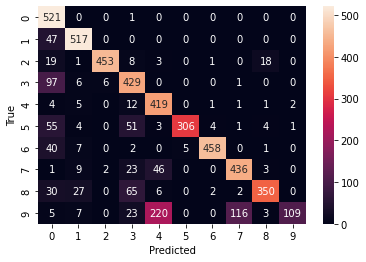

In [13]:
# train metrics
print(f'Training Accuracy: {metrics_obe_train.accuracy}')
print(f'Average Precision: {np.mean(metrics_obe_train.precision)}')
print(f'Precision per Class:')
for c in range(10):
    print(f'\t{c}: {metrics_obe_train.precision[c]}')
print(f'Average Recall: {np.mean(metrics_obe_train.recall)}')
print(f'Recall per Class:')
for c in range(10):
    print(f'\t{c}: {metrics_obe_train.recall[c]}')
print(f'Average F1-score: {np.mean(metrics_obe_train.f1_score)}')
print(f'F1-score per Class')
for c in range(10):
    print(f'\t{c}: {metrics_obe_train.f1_score[c]}')
metrics_obe_train.display_confusion_matrix()

Testing Accuracy: 0.678
Average Precision: 0.6724540606893903
Precision per Class:
	0: 0.958904109589041
	1: 0.8118466898954704
	2: 0.8188405797101449
	3: 0.7362204724409449
	4: 0.8072727272727273
	5: 0.40271493212669685
	6: 0.7466666666666667
	7: 0.7159533073929961
	8: 0.5867768595041323
	9: 0.13934426229508196
Average Recall: 0.7355138738945974
Recall per Class:
	0: 0.4772727272727273
	1: 0.8961538461538462
	2: 0.8593155893536122
	3: 0.5095367847411444
	4: 0.5766233766233766
	5: 0.9368421052631579
	6: 0.9333333333333333
	7: 0.7389558232931727
	8: 0.6543778801843319
	9: 0.7727272727272727
Average F1-score: 0.6577861521253345
F1-score per Class
	0: 0.637329286798179
	1: 0.8519195612431444
	2: 0.8385899814471242
	3: 0.602254428341385
	4: 0.6727272727272727
	5: 0.5632911392405063
	6: 0.8296296296296296
	7: 0.7272727272727272
	8: 0.6187363834422659
	9: 0.23611111111111108


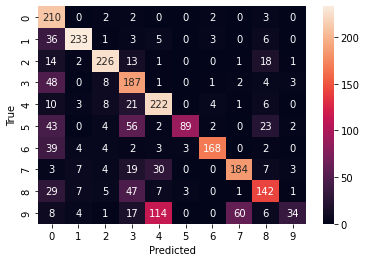

In [14]:
# test metrics
print(f'Testing Accuracy: {metrics_obe_test.accuracy}')
print(f'Average Precision: {np.mean(metrics_obe_test.precision)}')
print(f'Precision per Class:')
for c in range(10):
    print(f'\t{c}: {metrics_obe_test.precision[c]}')
print(f'Average Recall: {np.mean(metrics_obe_test.recall)}')
print(f'Recall per Class:')
for c in range(10):
    print(f'\t{c}: {metrics_obe_test.recall[c]}')
print(f'Average F1-score: {np.mean(metrics_obe_test.f1_score)}')
print(f'F1-score per Class')
for c in range(10):
    print(f'\t{c}: {metrics_obe_test.f1_score[c]}')
metrics_obe_test.display_confusion_matrix()

### 3. Comparison

As we can see, disregarding the Naive Bayes assumption here leads to better metrics all around. The reason for that, as discussed earlier, may be that although the Naive Bayes is usually a safe assumption to make even if it doesn't necessarily hold throughout the entire dataset, it is specially detrimental for this problem because of inherent qualities of the dataset. Namely, the fact that we are attempting to train a Bayes classifier on an image dataset of handwritten digits.

Handwritten digits are composed of connected areas of pixels with around the same pixel intensity. This means that the assumption that two neighboring pixels share no information at all (the Naive Bayes assumption of independence) is completely invalid because we expect neighboring pixels to have more or less the same pixel intensity.

## B. Naive Bayes Classification using scikit-learn

In order to verify the results of our implementation, we will use the tried and true Naive Bayes classifier from the scikit-learn library.

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
nb = GaussianNB()
nb.fit(train_features, train_targets)

GaussianNB()

In [16]:
# train metrics
y_pred_train = nb.predict(train_features)
print(f"Accuracy: {accuracy_score(train_targets, y_pred_train)}")
print(f"Average Precision: {precision_score(train_targets, y_pred_train, average='macro')}")
precision_per_class = precision_score(train_targets, y_pred_train, average=None)
print(f'Precision per Class:')
for c in range(10):
    print(f'\t{c}: {precision_per_class[c]}')
print(f"Average Recall: {recall_score(train_targets, y_pred_train, average='macro')}")
recall_per_class = recall_score(train_targets, y_pred_train, average=None)
print(f'Recall per Class:')
for c in range(10):
    print(f'\t{c}: {recall_per_class[c]}')
print(f"Average F1-score: {f1_score(train_targets, y_pred_train, average='macro')}")
f1_per_class = f1_score(train_targets, y_pred_train, average=None)
print(f'F1 per Class:')
for c in range(10):
    print(f'\t{c}: {f1_per_class[c]}')

Accuracy: 0.5802
Average Precision: 0.7165161034077474
Precision per Class:
	0: 0.7974683544303798
	1: 0.5572597137014315
	2: 0.9311926605504587
	3: 0.7763157894736842
	4: 0.8514851485148515
	5: 0.8541666666666666
	6: 0.7687188019966722
	7: 0.9120879120879121
	8: 0.27239819004524884
	9: 0.4440677966101695
Average Recall: 0.5683153509716203
Recall per Class:
	0: 0.8448275862068966
	1: 0.9663120567375887
	2: 0.40357852882703776
	3: 0.32838589981447125
	4: 0.3865168539325843
	5: 0.09557109557109557
	6: 0.9005847953216374
	7: 0.3192307692307692
	8: 0.6244813278008299
	9: 0.8136645962732919
Average F1-score: 0.5511848415295715
F1 per Class:
	0: 0.8204651162790698
	1: 0.7068741893644618
	2: 0.5631067961165048
	3: 0.4615384615384615
	4: 0.5316846986089644
	5: 0.1719077568134172
	6: 0.8294434470377019
	7: 0.4729344729344729
	8: 0.37933207309388783
	9: 0.5745614035087719


In [17]:
# test metrics
y_pred_test = nb.predict(test_features)
print(f"Accuracy: {accuracy_score(test_targets, y_pred_test)}")
print(f"Average Precision: {precision_score(test_targets, y_pred_test, average='macro')}")
precision_per_class = precision_score(test_targets, y_pred_test, average=None)
print(f'Precision per Class:')
for c in range(10):
    print(f'\t{c}: {precision_per_class[c]}')
print(f"Average Recall: {recall_score(test_targets, y_pred_test, average='macro')}")
recall_per_class = recall_score(test_targets, y_pred_test, average=None)
print(f'Recall per Class:')
for c in range(10):
    print(f'\t{c}: {recall_per_class[c]}')
print(f"Average F1-score: {f1_score(test_targets, y_pred_test, average='macro')}")
f1_per_class = f1_score(test_targets, y_pred_test, average=None)
print(f'F1 per Class:')
for c in range(10):
    print(f'\t{c}: {f1_per_class[c]}')

Accuracy: 0.5068
Average Precision: 0.6571426823189541
Precision per Class:
	0: 0.7777777777777778
	1: 0.5304182509505704
	2: 0.8021978021978022
	3: 0.7469879518072289
	4: 0.7676767676767676
	5: 0.8333333333333334
	6: 0.6198630136986302
	7: 0.8571428571428571
	8: 0.24734982332155478
	9: 0.3886792452830189
Average Recall: 0.5084718546114242
Recall per Class:
	0: 0.7990867579908676
	1: 0.9721254355400697
	2: 0.2644927536231884
	3: 0.2440944881889764
	4: 0.27636363636363637
	5: 0.06787330316742081
	6: 0.8044444444444444
	7: 0.23346303501945526
	8: 0.5785123966942148
	9: 0.8442622950819673
Average F1-score: 0.4718348258080933
F1 per Class:
	0: 0.7882882882882882
	1: 0.6863468634686347
	2: 0.3978201634877384
	3: 0.36795252225519287
	4: 0.4064171122994652
	5: 0.12552301255230125
	6: 0.7001934235976789
	7: 0.3669724770642202
	8: 0.34653465346534656
	9: 0.5322997416020673


As we can see, the results of the scikit-learn implementation is comparable to the ones from our own implementation of the Naive Bayes classifier.

# Problem 2

## A. Preparation

Importing relevant libraries.

In [18]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

Importing the dataset and extracting the relevant features for classifications.

In [19]:
dataset = pd.read_csv("data/IRIS-Dataset/Iris.csv")
features = dataset[["Petal_Length", "Petal_Width"]].to_numpy()
targets = dataset["Class"]
# map each class to a color. later used for plotting.
color_mapping = {
    "Iris-setosa": "red",
    "Iris-versicolor": "black",
    "Iris-virginica": "blue"
}

## B. Experiements

### 1. SVM with Linear Kernel, one-vs-rest

In [20]:
classifier = SVC(decision_function_shape='ovr', kernel='linear')
classifier.fit(features, targets)

SVC(kernel='linear')

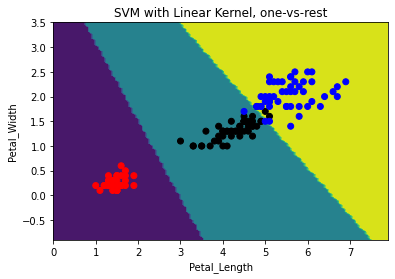

In [21]:
DecisionBoundaryDisplay.from_estimator(
    classifier,
    features,
    response_method="predict",
    xlabel="Petal_Length",
    ylabel="Petal_Width"
)
plt.title("SVM with Linear Kernel, one-vs-rest")
plt.scatter(features[:,0], features[:,1], c=targets.map(color_mapping))
plt.show()

Accuracy on training set: 0.9666666666666667


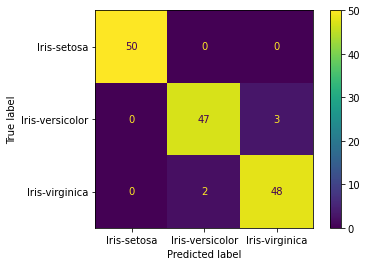

In [22]:
print(f"Accuracy on training set: {accuracy_score(targets, classifier.predict(features))}")
display = ConfusionMatrixDisplay.from_estimator(classifier, features, targets)

### 2. SVM with Linear Kernel, one-vs-one

In [23]:
classifier = SVC(decision_function_shape='ovo', kernel='linear')
classifier.fit(features, targets)

SVC(decision_function_shape='ovo', kernel='linear')

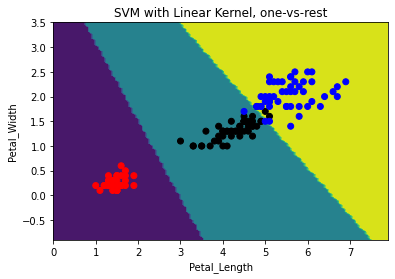

In [24]:
DecisionBoundaryDisplay.from_estimator(
    classifier,
    features,
    response_method="predict",
    xlabel="Petal_Length",
    ylabel="Petal_Width"
)
plt.title("SVM with Linear Kernel, one-vs-rest")
plt.scatter(features[:,0], features[:,1], c=targets.map(color_mapping))
plt.show()

Accuracy on training set: 0.9666666666666667


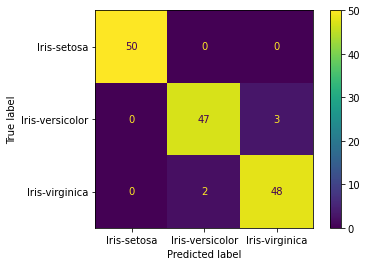

In [25]:
print(f"Accuracy on training set: {accuracy_score(targets, classifier.predict(features))}")
display = ConfusionMatrixDisplay.from_estimator(classifier, features, targets)

### 3. SVM with RBF Kernel, one-vs-rest

In [26]:
classifier = SVC(decision_function_shape='ovr', kernel='rbf')
classifier.fit(features, targets)

SVC()

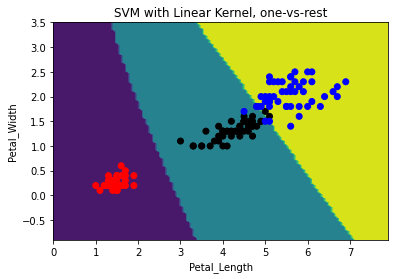

In [27]:
DecisionBoundaryDisplay.from_estimator(
    classifier,
    features,
    response_method="predict",
    xlabel="Petal_Length",
    ylabel="Petal_Width"
)
plt.title("SVM with Linear Kernel, one-vs-rest")
plt.scatter(features[:,0], features[:,1], c=targets.map(color_mapping))
plt.show()

Accuracy on training set: 0.9533333333333334


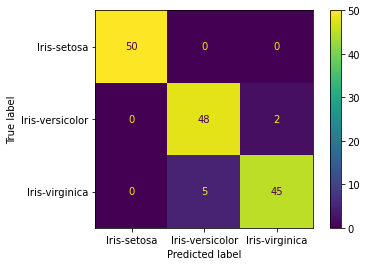

In [28]:
print(f"Accuracy on training set: {accuracy_score(targets, classifier.predict(features))}")
display = ConfusionMatrixDisplay.from_estimator(classifier, features, targets)

### 4. SVM with Polynomial Kernel (d=3), one-vs-rest

In [29]:
classifier = SVC(decision_function_shape='ovr', kernel='poly', degree=3)
classifier.fit(features, targets)

SVC(kernel='poly')

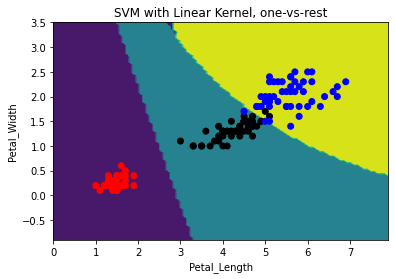

In [30]:
DecisionBoundaryDisplay.from_estimator(
    classifier,
    features,
    response_method="predict",
    xlabel="Petal_Length",
    ylabel="Petal_Width"
)
plt.title("SVM with Linear Kernel, one-vs-rest")
plt.scatter(features[:,0], features[:,1], c=targets.map(color_mapping))
plt.show()

Accuracy on training set: 0.9666666666666667


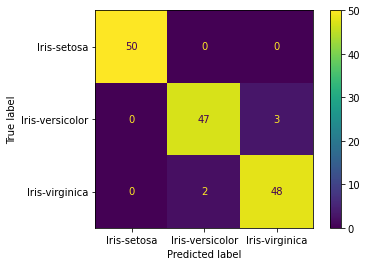

In [31]:
print(f"Accuracy on training set: {accuracy_score(targets, classifier.predict(features))}")
display = ConfusionMatrixDisplay.from_estimator(classifier, features, targets)

# Problem 3

## A. Dataset loading and preprocessing

Reading the Social Network Ads dataset and separating the features from the labels.

In [32]:
dataset = pd.read_csv("data/Social_Network_Ads.csv").to_numpy()

In [33]:
print(f'Dataset Class Distribution: {np.count_nonzero(dataset[:,2] == 1)} vs. {np.count_nonzero(dataset[:,2] == 0)}')

Dataset Class Distribution: 143 vs. 257


As we can see, the dataset is slightly imbalanced. Decision trees do not perform well against imbalanced datasets. In order to combat this, we will use SMOTE to oversample the minority class. This technique, in a nut shell, interpolates between the minority classes to generate new data points in order to balance the scale between the minority and the majority classes. More on SMOTE here: https://towardsdatascience.com/smote-fdce2f605729


Because oversampling is not valid on the testing set, we must first extract a balanced testing set from the real data and perform oversampling on the training set only. We will use 80% of the available data for training and 20% for testing purposes. 

In [34]:
test_split = 0.2*len(dataset)
class_0_choices = np.random.choice(np.where(dataset[:,2] == 0)[0], int(test_split/2), replace=False)
class_1_choices = np.random.choice(np.where(dataset[:,2] == 1)[0], int(test_split/2), replace=False)
test_set = np.concatenate((dataset[class_0_choices, :], dataset[class_1_choices, :]))
np.random.shuffle(test_set)
X_test = test_set[:, :2]
Y_test = test_set[:, 2]
training_set = np.delete(dataset, np.concatenate((class_0_choices, class_1_choices)), axis=0)
np.random.shuffle(training_set)

In [35]:
test_set.shape

(80, 3)

In [36]:
training_set.shape

(320, 3)

In [37]:
print(f'Testing Class Distribution: {np.count_nonzero(Y_test == 1)} vs. {np.count_nonzero(Y_test == 0)}')

Testing Class Distribution: 40 vs. 40


Now that we have a balanced split of the testing set we can run SMOTE on the training set.

In [38]:
# we use imbalance-learn to perform SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train, Y_train = smote.fit_resample(training_set[:,:2], training_set[:, 2])

In [39]:
print(f'Training Class Distribution: {np.count_nonzero(Y_train == 1)} vs. {np.count_nonzero(Y_train == 0)}')

Training Class Distribution: 217 vs. 217


As we can see, we now have a balanced training set as well as a balanced test set. We can now fit a Decision Tree to the training set.

## B. Fitting a Decision Tree on top of the dataset

In [40]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, Y_train)

DecisionTreeClassifier()

## C. Reporting Metrics and Displaying Confusion Matrix

Making predictions on the train and test sets.

In [41]:
y_pred_test = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

Plotting the Confusion Matrix and reporting the accuracy on each dataset.

Accuracy on test set: 0.8625


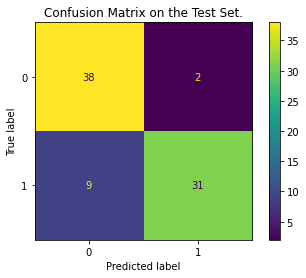

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
print(f"Accuracy on test set: {accuracy_score(Y_test, y_pred_test)}")
display = ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred_test))
display.plot()
plt.title("Confusion Matrix on the Test Set.")
plt.show()

Accuracy on train set: 1.0


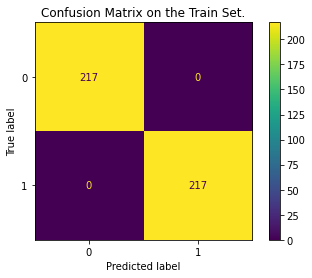

In [43]:
print(f"Accuracy on train set: {accuracy_score(Y_train, y_pred_train)}")
display = ConfusionMatrixDisplay(confusion_matrix(Y_train, y_pred_train))
display.plot()
plt.title("Confusion Matrix on the Train Set.")
plt.show()

We achieve a near perfect accuracy on the training set with only 2 misclassified examples. However, the accuracy on the test set is less than ideal. We will address this issue later in "Appendix I" of this problem.

## D. Decision Surface of the Trained Decision Tree

We can view the decision surface of the trained DT on each dataset.

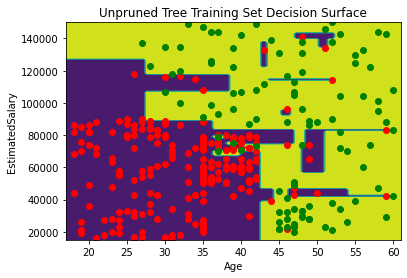

In [44]:
from sklearn.inspection import DecisionBoundaryDisplay
DecisionBoundaryDisplay.from_estimator(
        dt,
        dataset[:,:2],
        response_method="predict",
        xlabel="Age",
        ylabel="EstimatedSalary",
    )
plt.title("Unpruned Tree Training Set Decision Surface")
plt.scatter(training_set[np.where(training_set[:,2]==0), 0], training_set[np.where(training_set[:,2]==0), 1], color='red')
plt.scatter(training_set[np.where(training_set[:,2]==1), 0], training_set[np.where(training_set[:,2]==1), 1], color='green')
plt.show()

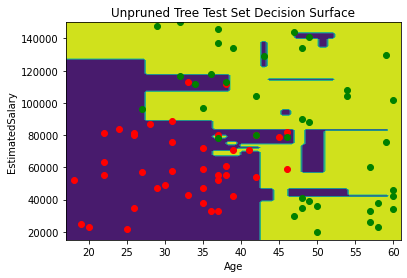

In [45]:
DecisionBoundaryDisplay.from_estimator(
        dt,
        dataset[:,:2],
        response_method="predict",
        xlabel="Age",
        ylabel="EstimatedSalary",
    )
plt.title("Unpruned Tree Test Set Decision Surface")
plt.scatter(test_set[np.where(test_set[:,2]==0), 0], test_set[np.where(test_set[:,2]==0), 1], color='red')
plt.scatter(test_set[np.where(test_set[:,2]==1), 0], test_set[np.where(test_set[:,2]==1), 1], color='green')
plt.show()

As we can see, the resulting decision surface is extremely complicated.

## E. Plotting the Decision Tree

A picture is worth a thousand words; so in order to understand just how complicated an unpruned decision tree is, we can plot the tree in human-readable form.

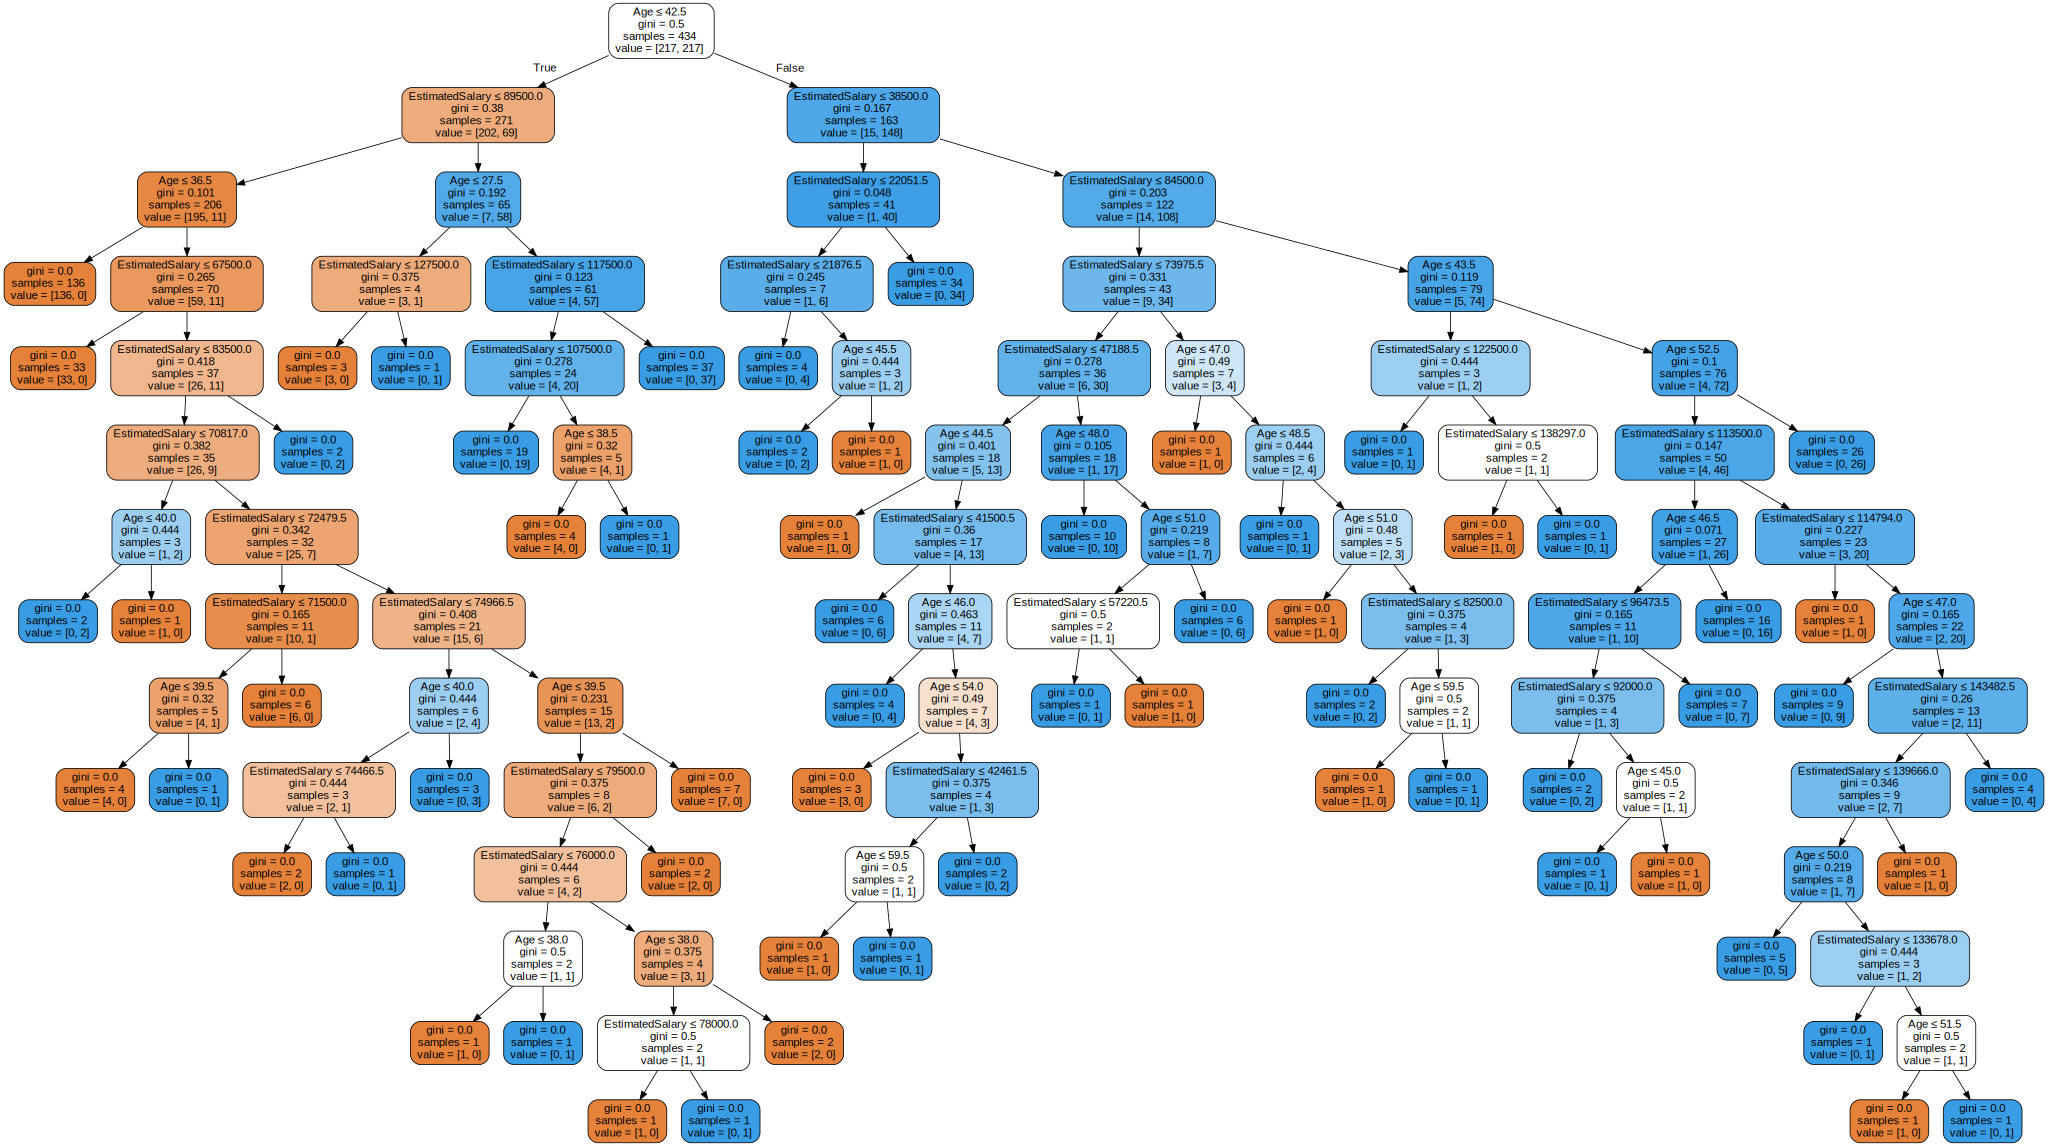

In [46]:
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=["Age", "EstimatedSalary"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Appendix I: Mitigating the Overfitting Issue

The Decision Tree trained in the previous sections is extremely complicated and visible overfits the dataset.
However, if we apply a max_depth=2 pre-pruning method, we will achieve more desirable results.

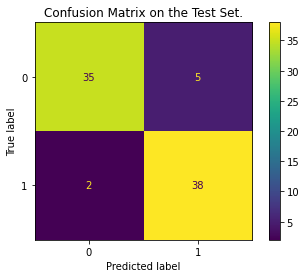

In [47]:
dt_pruned = tree.DecisionTreeClassifier(max_depth=2)
dt_pruned.fit(X_train, Y_train)
y_pred = dt_pruned.predict(X_test)
display = ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred))
display.plot()
plt.title("Confusion Matrix on the Test Set.")
plt.show()

As we can see, this Decision Tree performs much better on the Test Set.
The tree is also much simpler now, structurally.

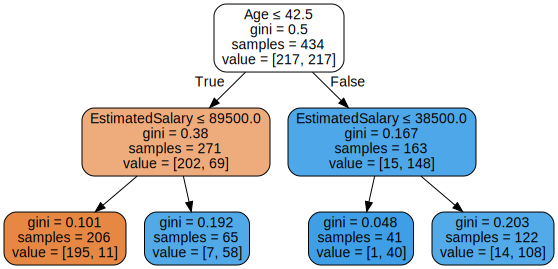

In [48]:
dot_data = tree.export_graphviz(dt_pruned, out_file=None, 
                     feature_names=["Age", "EstimatedSalary"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data) 
graph 

We can now plot the decision surface of the pruned Decision Tree on the train set ...

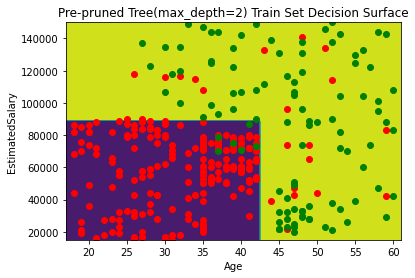

In [49]:
DecisionBoundaryDisplay.from_estimator(
        dt_pruned,
        dataset[:,:2],
        response_method="predict",
        xlabel="Age",
        ylabel="EstimatedSalary",
    )
plt.title("Pre-pruned Tree(max_depth=2) Train Set Decision Surface")
plt.scatter(training_set[np.where(training_set[:,2]==0), 0], training_set[np.where(training_set[:,2]==0), 1], color='red')
plt.scatter(training_set[np.where(training_set[:,2]==1), 0], training_set[np.where(training_set[:,2]==1), 1], color='green')
plt.show()

... and the test set.

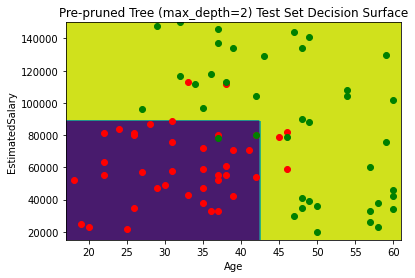

In [50]:
DecisionBoundaryDisplay.from_estimator(
        dt_pruned,
        dataset[:,:2],
        response_method="predict",
        xlabel="Age",
        ylabel="EstimatedSalary",
    )
plt.title("Pre-pruned Tree (max_depth=2) Test Set Decision Surface")
plt.scatter(test_set[np.where(test_set[:,2]==0), 0], test_set[np.where(test_set[:,2]==0), 1], color='red')
plt.scatter(test_set[np.where(test_set[:,2]==1), 0], test_set[np.where(test_set[:,2]==1), 1], color='green')
plt.show()